### File: Model Optimization

##### Goals and Objectives of this file:

##### 1. Basic Model Training and Word Embedding Testing
##### 2. Data Processing => over/under sampling the classes  =>  word embeddings => Mnnb Hyperparameter Tuning
##### 3. Several Classifiers Testing => Different ML Algorithms tests => (hyper)parameter Tuning
##### 4. Training and Testing => accuracy => precision => confusion matrix => roc/auc curves => learning curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import imblearn
import pickle
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

### 1. Basic Model Training and Vectorizer Testing

In [2]:
df = pd.read_csv("datasets/yelp coffee/raw_yelp_review_data_processed.csv")

In [3]:
def remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

In [4]:
df['full_review_text'] = [remove_stop_words(text) for text in df['full_review_text']]

In [5]:
X = df['full_review_text']
y = df['star_rating']

In [6]:
def create_data_split(X,y,vectorizer=False,test_size = 0.2):
    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size,random_state = 42)
    if vectorizer:
        vectorizer = vectorizer
        train_embed = vectorizer.fit_transform(x_train)
        test_embed = vectorizer.transform(x_test)
        return train_embed,test_embed,y_train,y_test
    else:
        return x_train,x_test,y_train,y_test

In [7]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,TfidfVectorizer())

In [8]:
model_NB = MultinomialNB()
model_NB.fit(x_train_tfidf, y_train)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 47.94%


### This result can be better...

### 2. Data Processing

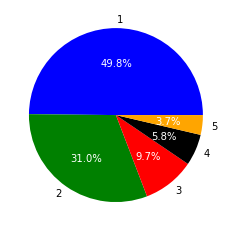

In [9]:
_, _, autotexts = plt.pie(y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

### This dataset will be balanced using several different techniques.

### 2.1 Data Resampling

#### Random Oversampling

In [10]:
random_oversampler = RandomOverSampler(random_state=42)
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

In [11]:
ro_y.value_counts()

5    2787
1    2787
4    2787
2    2787
3    2787
Name: star_rating, dtype: int64

In [12]:
model_NB = MultinomialNB()
model_NB.fit(ro_x_tfidf, ro_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 53.00%


#### Random Undersampling

In [13]:
random_underSampler = RandomUnderSampler(random_state=42)
ru_x_tfidf,ru_y = random_underSampler.fit_resample(x_train_tfidf, y_train)

In [14]:
ru_y.value_counts()

1    200
2    200
3    200
4    200
5    200
Name: star_rating, dtype: int64

In [15]:
model_NB = MultinomialNB()
model_NB.fit(ru_x_tfidf, ru_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 42.73%


#### SMOTE

In [16]:
smote_resample = SMOTE(random_state=42)
smote_x_tfidf,smote_y = smote_resample.fit_resample(x_train_tfidf, y_train)

In [17]:
smote_y.value_counts()

5    2787
1    2787
4    2787
2    2787
3    2787
Name: star_rating, dtype: int64

In [18]:
model_NB = MultinomialNB()
model_NB.fit(smote_x_tfidf, smote_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 50.33%


### According to the accuracy results: Random Oversampling was the best method for data resampling.

### 2.2 Word Embeddings

### Word2Vec (BoW)

In [19]:
#bow_vectorizer = CountVectorizer(ngram_range=(1, 2),encoding = 'utf-8',binary=False)
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(X)
bow_array = bow_matrix.toarray()
bow_df = pd.DataFrame(data=bow_array,columns = bow_vectorizer.vocabulary_.keys())

In [20]:
bow_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#bow_df.describe()

In [22]:
(bow_df['love'] != 0).sum()

8

### TF-IDF 

In [23]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = tf_idf_vectorizer.fit_transform(X)
tf_idf_array = bow_matrix.toarray()
tf_idf_df = pd.DataFrame(data=tf_idf_array,columns=bow_vectorizer.vocabulary_.keys())

In [24]:
tf_idf_df.head()

,love,loved,atmosphere,every,corner,coffee,shop,style,swing,ordered,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#tf_idf_df.describe()

In [26]:
(tf_idf_df['love'] != 0).sum()

8

### Word2Vec vs TF-IDF (with Random Resampling)

In [27]:
random_oversampler = RandomOverSampler(random_state=42)

In [28]:
x_train_bow,x_test_bow,y_train,y_test = create_data_split(X,y,vectorizer=bow_vectorizer)
ro_x_bow,ro_y = random_oversampler.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(ro_x_bow, ro_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 55.24%


In [29]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,vectorizer=TfidfVectorizer())
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)
model_NB = MultinomialNB()
model_NB.fit(ro_x_tfidf, ro_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 53.00%


### Based on the previous results: Word2Vec Outperformed TF-IDF

### Now, the next step is to find the best resampling technique for Word2Vec

In [30]:
random_underSampler = RandomUnderSampler(random_state=42)

In [31]:
ru_x_bow,ru_y = random_underSampler.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(ru_x_bow, ru_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 37.82%


In [32]:
smote_resample = SMOTE(random_state=42)

In [33]:
smote_x_bow,smote_y = smote_resample.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(smote_x_bow, smote_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 57.12%


In [34]:
y_pred = model_NB.predict(x_test_bow)
print("Random Forest Classification Report = \n ",metrics.classification_report(y_test,y_pred))

Random Forest Classification Report = 
                precision    recall  f1-score   support

           1       0.56      0.19      0.28        53
           2       0.26      0.13      0.17        69
           3       0.36      0.19      0.25       157
           4       0.48      0.56      0.51       445
           5       0.68      0.75      0.71       659

    accuracy                           0.57      1383
   macro avg       0.47      0.36      0.39      1383
weighted avg       0.55      0.57      0.55      1383



### Based on these results: SMOTE was the best resampling technique specifically for Word2Vec

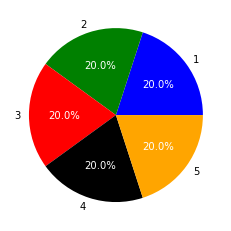

In [35]:
_, _, autotexts = plt.pie(smote_y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

In [36]:
smote_x_bow

<13935x16530 sparse matrix of type '<class 'numpy.int64'>'
	with 773296 stored elements in Compressed Sparse Row format>

### 2.3 Hyperparameter Tuning on the MNB model.

### First Step: Validation split

### Dataset will be split further from train-test into train-validation-test to better evaluate the model.

#### some definitons:

#### 1. x_train_cont = x_bow with smote resampling and validation split

#### 2. x_val = x_test with smote resampling and validation split

#### 3. y_train_val = y_train with smote resampling and validation split

#### 4. y_val = y_test with smote resampling and validation split

In [37]:
x_train_val, x_val, y_train_val, y_val = create_data_split(smote_x_bow, smote_y, test_size=0.25) # 0.25 x 0.8 = 0.2

### Second Step: Hyperparameter Tuning

### 1. Grid Search

In [38]:
param_grid = {"alpha": range(1,10)}
mnnb = MultinomialNB()
grid_search = GridSearchCV(mnnb, param_grid,cv=5, verbose=2)

grid_search.fit(x_train_val, y_train_val)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=2; total time=   0.0s
[CV] END ............................................alpha=3; total time=   0.0s
[CV] END ........................................

In [39]:
print(grid_search.score(x_train_val, y_train_val))
print(grid_search.score(x_val, y_val))

0.6997416515166013
0.5938576349024111


### 2. Randomized hyperparameter optimization

In [40]:
mnnb = MultinomialNB()
random_search = RandomizedSearchCV(mnnb, param_grid, cv=5, verbose=2, n_jobs=-1, n_iter=5)
random_search.fit(x_train_val, y_train_val)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': range(1, 10)}, verbose=2)

In [41]:
random_search.score(x_val, y_val)

0.5938576349024111

### Based on these results, the alpha value is best kept at default (1.0) as there is beneficial progess that occurs after that point.

### 3. Several Classifiers Testing

### First Step: Machine Learning Algorithms

### 3.1 Different Algorithms

### 1. Random Forest

In [42]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train_val, y_train_val)
y_pred_rf = rf_clf.predict(x_val)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Accuracy:", accuracy_rf)

Accuracy: 0.736796785304248


### 2. SVM

In [43]:
svm_clf = SVC(kernel='rbf', C=10, gamma=0.1,random_state = 42)
svm_clf.fit(x_train_val, y_train_val)
y_pred_svm = svm_clf.predict(x_val)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print("Accuracy:", accuracy_svm)

Accuracy: 0.6928817451205511


### 3. Ensemble (Bagging) Model (KNN) 

In [44]:
ens_knn_clf = BaggingClassifier(KNeighborsClassifier(),random_state = 42)
ens_knn_clf.fit(x_train_val, y_train_val)
y_pred_ens_knn = ens_knn_clf.predict(x_val)
accuracy_ens_knn = accuracy_score(y_val, y_pred_ens_knn)
print("Accuracy:", accuracy_ens_knn)

Accuracy: 0.5505166475315729


### 4. Ensemble (Bagging) Model (MNNB)

In [45]:
ens_mnnb_clf = BaggingClassifier(MultinomialNB(),random_state = 42)
ens_mnnb_clf.fit(x_train_val, y_train_val)
y_pred_ens_mnnb = ens_mnnb_clf.predict(x_val)
accuracy_ens_mnnb = accuracy_score(y_val, y_pred_ens_mnnb)
print("Accuracy:", accuracy_ens_mnnb)

Accuracy: 0.5901262916188289


### 5. Ensemble (Adaboost) Model (MNNB)

In [46]:
ens_mnnb_clf = AdaBoostClassifier(MultinomialNB(),random_state = 42)
ens_mnnb_clf.fit(x_train_val, y_train_val)
y_pred_ens_mnnb_ada = ens_mnnb_clf.predict(x_val)
accuracy_ens_mnnb_ada = accuracy_score(y_val, y_pred_ens_mnnb_ada)
print("Accuracy:", accuracy_ens_mnnb_ada)

Accuracy: 0.5364523536165328


### 6. Gradient Boosting (XGBoost)

#### Some Label adjustments specifically for XGBoost

In [47]:
y_train_xgb = []
y_val_xgb = []

for label in y_train_val:
    y_train_xgb.append(label - 1)
    
for label in y_val:
    y_val_xgb.append(label - 1)

#### Model Training

In [48]:
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(x_train_val, y_train_xgb)
y_pred_xgb = xgb_model.predict(x_val)
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.8659586681974741


### Based on these results, The best ML model was XGBoost

### 3.2 Parameter Tuning

In [49]:
num_cv = 5

In [50]:
params = {'learning_rate': [0.1, 0.2,0.3],
              'max_depth': [5, 7, 9],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.5, 0.7, 1.0],
              'colsample_bytree': [0.5, 0.7, 1.0],
              'gamma':[1,2,3],
              'alpha':[0.001,0.01,0.1],
         }

In [51]:
# try:
#     pickle.load(open("best_params.pickle", "rb"))
#     raise SystemExit("Found Pickle File. Execute Next cell.")
# except:
#     xgb_clf = XGBClassifier(random_state = 42)
#     grid_search = GridSearchCV(xgb_clf, params,cv=num_cv, verbose=2)
#     grid_search.fit(x_train_val, y_train_xgb)

#     pickle_out = open('best_params.pickle','wb')
#     pickle.dump(grid_search.best_params_,pickle_out)
#     pickle_out.close()

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 1.0}

In [52]:
best_params = pickle.load(open("best_params.pickle", "rb"))
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 1.0}

In [53]:
xgb_model_new = XGBClassifier(colsample_bytree = 0.7,
 learning_rate = 0.3,
 max_depth = 9,
 min_child_weight = 1,
 subsample = 1.0,
 random_state = 42)
xgb_model_new.fit(x_train_val, y_train_xgb)
y_pred_xgb = xgb_model_new.predict(x_val)
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.8648105625717566
